<a href="https://colab.research.google.com/github/roesta07/Modeling-COVID-19/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.8
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz --no-dependencies
    !pip install netCDF4
    !pip install xarray


Requirement already up-to-date: daft in /usr/local/lib/python3.6/dist-packages (0.1.0)
Requirement already up-to-date: theano in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [80]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
from theano import theano

sampler_kwargs={'chains':4,'cores':4}

from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [57]:
## lets bring the who data
def load_covid_timeseries(name):
  base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
  url=f'{base_url}/time_series_covid19_{name}_global.csv'
  df=pd.read_csv(url,
                index_col=['Country/Region', 'Province/State', 'Lat', 'Long']) 
  df['type']=name.lower()
  df.columns.name='date'
  df=df.set_index('type',append=True).reset_index(['Lat','Long'],drop=True).stack().reset_index().set_index('date')
  df.index = pd.to_datetime(df.index)

  df.columns=['country', 'state', 'type', 'cases']
  df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
  df.loc[df.state =='Hong Kong', 'state'] = np.nan
  return df

def load_covid_data(type):
  df=load_covid_timeseries(type)
  df=df.rename(columns={'cases':type.lower()})
  df=days_after_100(df)
  return df

def days_after_100(df):
  df=df.loc[(df['confirmed']>100)]
  df.loc[:,'days_since_100']=np.nan
  for country in df.country.unique():
    filt=(df['country']==country)
    length=len(df.loc[filt,'days_since_100'].values)
    counter=np.arange(0,length).astype(int)
    df.loc[filt,'days_since_100']=counter.astype(int) ## this did not convert into integer
  return df

In [58]:
df=load_covid_data('confirmed')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [59]:
df.head()
df['days_since_100']=df['days_since_100'].astype(int)

In [136]:
def standarize(col):
  return (col-col.mean())/col.std()

Text(0, 0.5, 'confirmed cases')

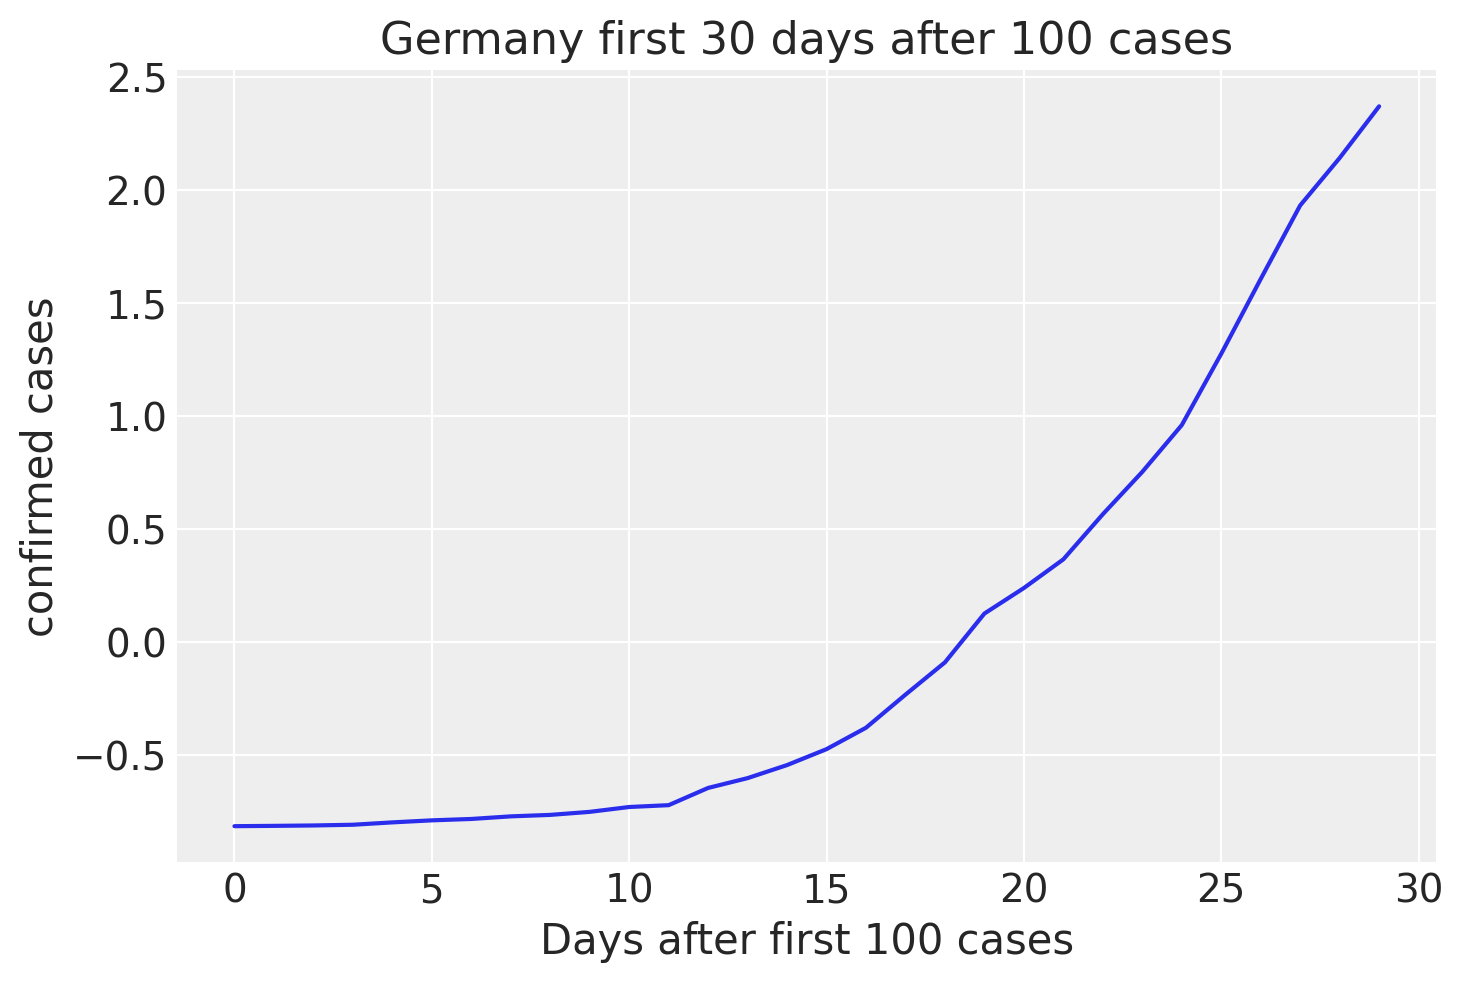

In [137]:
country='Germany'
df_country=df.loc[df['country']==country].iloc[:30]

plt.plot(df_country['days_since_100'],standarize(df_country['confirmed']))
plt.title('Germany first 30 days after 100 cases')
plt.xlabel('Days after first 100 cases')
plt.ylabel('confirmed cases')

In [138]:
(100-df_country['confirmed'].mean())/df_country['confirmed'].std()

-0.8168486566669898

In [107]:
t=df_country.days_since_100.values
confirmed=standarize(df_country.confirmed.values)
## modelling covid
with pm.Model() as m4_1:
  a=pm.Normal('a',0,100)
  b=pm.Normal('b',0.3,0.1)
  sigma=pm.HalfNormal('sigma',100)
  growth_mu=pm.Deterministic('growth_mu', a * (1 + b)**t)

  cases=pm.Normal('cases',mu=growth_mu,sigma=sigma,observed=confirmed)

In [108]:
prior_m41=pm.sample_prior_predictive(100,m4_1)

[(-1000.0, 1000.0), Text(0, 0.5, 'cases'), (0.0, 10.0), Text(0.5, 0, 'Days')]

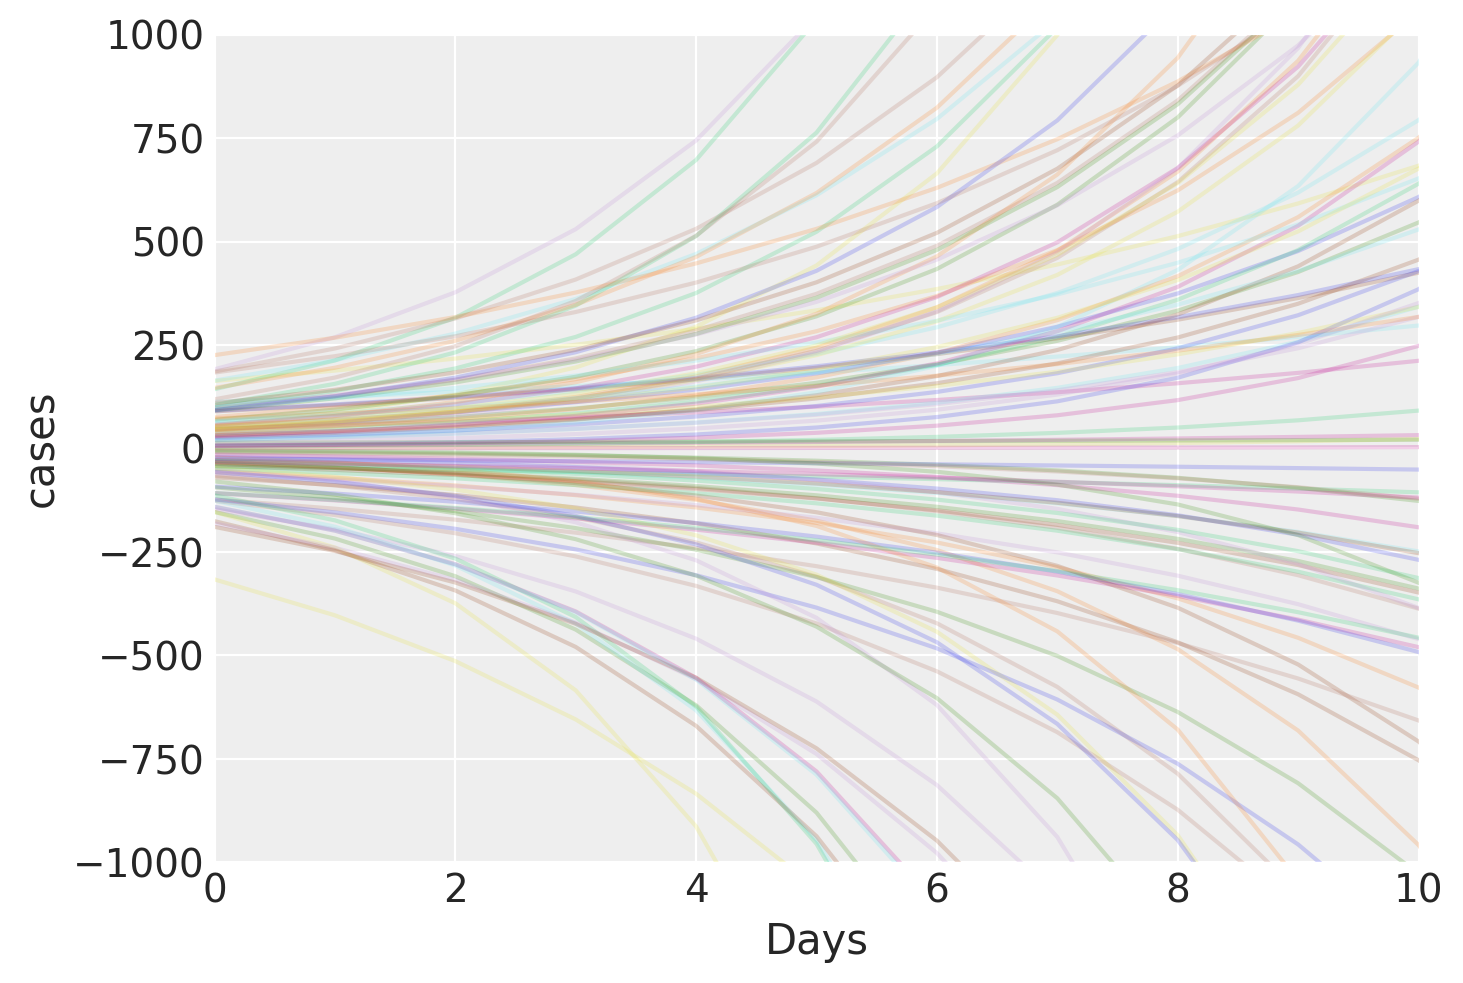

In [110]:
fig,ax=plt.subplots()
ax.plot(prior_m41['growth_mu'].T,alpha=0.2)
ax.set(xlabel='Days',ylabel='cases',ylim=(-1000,1000),xlim=(0,10),
       )

In [65]:
with m4_1:
  trace4_1=pm.sample(tune=0,draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
Sampling chain 1, 499 divergences: 100%|██████████| 500/500 [00:01<00:00, 459.76it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [151]:
t=df_country.days_since_100.values
confirmed=standarize(df_country.confirmed.values)
## modelling covid
with pm.Model() as m4_exp2:
  a=pm.Normal('a',-1,0.2)
  b=pm.Normal('b',-0.2,0.1)
  sigma=pm.Exponential('sigma',1)
  growth_mu=pm.Deterministic('growth_mu', a * (1 + b)**t)

  cases=pm.Normal('cases',growth_mu,
                            sigma,
                            observed=confirmed)

array([-0.82935638, -0.82794842, -0.82615205, -0.82294772, -0.81226663,
       -0.80313914, -0.79687614, -0.78517548, -0.77857262, -0.76492995,
       -0.7430337 , -0.73478013, -0.65724508, -0.61306418, -0.55431815,
       -0.48260915, -0.38623653, -0.23718669, -0.09187523,  0.12796115,
        0.24278294,  0.3719271 ,  0.57501358,  0.7658168 ,  0.97638005,
        1.2975412 ,  1.63414138,  1.96544957,  2.1790715 ,  2.41162809])

In [152]:
prior4_exp2=pm.sample_prior_predictive(50,m4_exp2)

100.0

[(-3.0, 3.0),
 Text(0, 0.5, 'confirmed cases'),
 (0.0, 10.0),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'prior m4_exp2')]

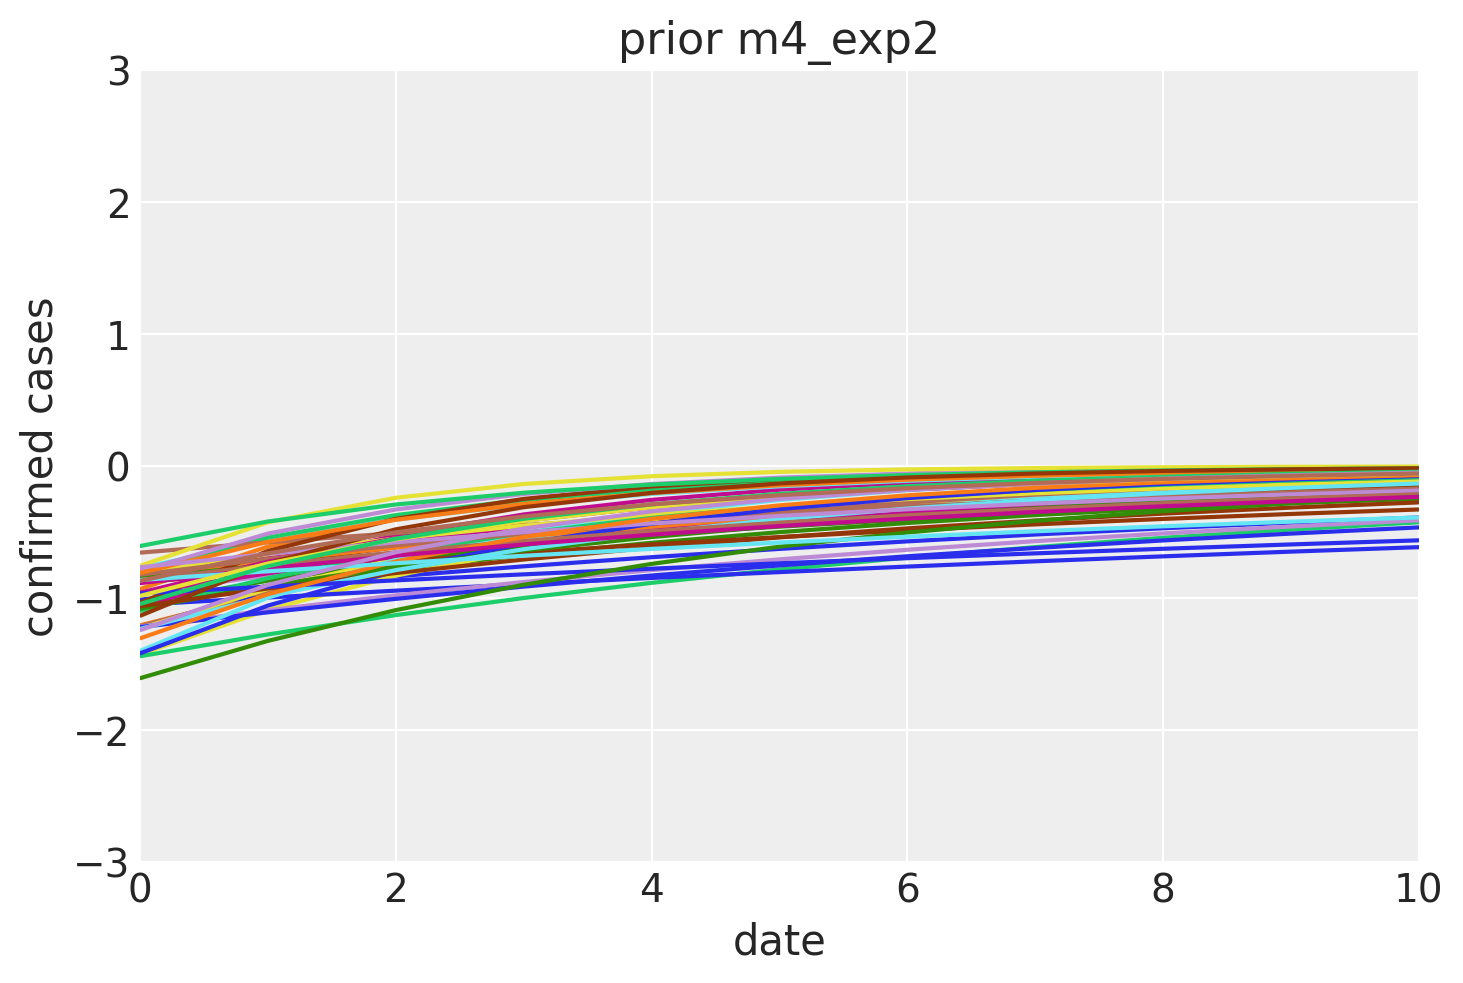

In [153]:
fig,ax=plt.subplots()
ax.plot(prior4_exp2['growth_mu'].T)
ax.set(xlabel='date',ylabel='confirmed cases',title='prior m4_exp2',ylim=(-3,3),xlim=(0,10))
# ex=np.linspace(-1000,1000,6)
# ax.set_yticks(ex)
# ax.set_yticklabels(ex*confirmed.std()+confirmed.mean())

In [130]:
with m4_exp2:
  trace4_exp2=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
Sampling chain 1, 0 divergences:  20%|██        | 200/1000 [00:03<00:14, 54.48it/s]


ValueError: ignored

In [122]:
az.summary(trace4_exp2)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,99.741,0.271,99.471,100.012,0.190,0.160,2.0,2.0,2.0,2.0,14462920.06
b,0.393,0.075,0.318,0.468,0.052,0.044,2.0,2.0,2.0,2.0,14462920.06
sigma,0.531,0.267,0.264,0.797,0.187,0.158,2.0,2.0,2.0,2.0,14462920.06
growth_mu[0],99.741,0.271,99.471,100.012,0.190,0.160,2.0,2.0,2.0,2.0,14462920.06
growth_mu[1],138.956,7.827,131.133,146.778,5.490,4.636,2.0,2.0,2.0,2.0,14462920.06
growth_mu[2],194.144,21.280,172.875,215.413,14.926,12.604,2.0,2.0,2.0,2.0,14462920.06
growth_mu[3],272.022,44.142,227.903,316.142,30.962,26.145,2.0,2.0,2.0,2.0,14462920.06
growth_mu[4],382.210,81.804,300.447,463.973,57.380,48.452,2.0,2.0,2.0,2.0,14462920.06
growth_mu[5],538.507,142.495,396.083,680.930,99.950,84.398,2.0,2.0,2.0,2.0,14462920.06
growth_mu[6],760.750,238.709,522.161,999.339,167.437,141.384,2.0,2.0,2.0,2.0,14462920.06
